# With solution length, only one set of parameters


Solving problem 1
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 2
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 3
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 4
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 5
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 6
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 7
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 8
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 9
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 10
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 11
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 12
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 13
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 14
Using manhattan...
Using misplaced...
Us

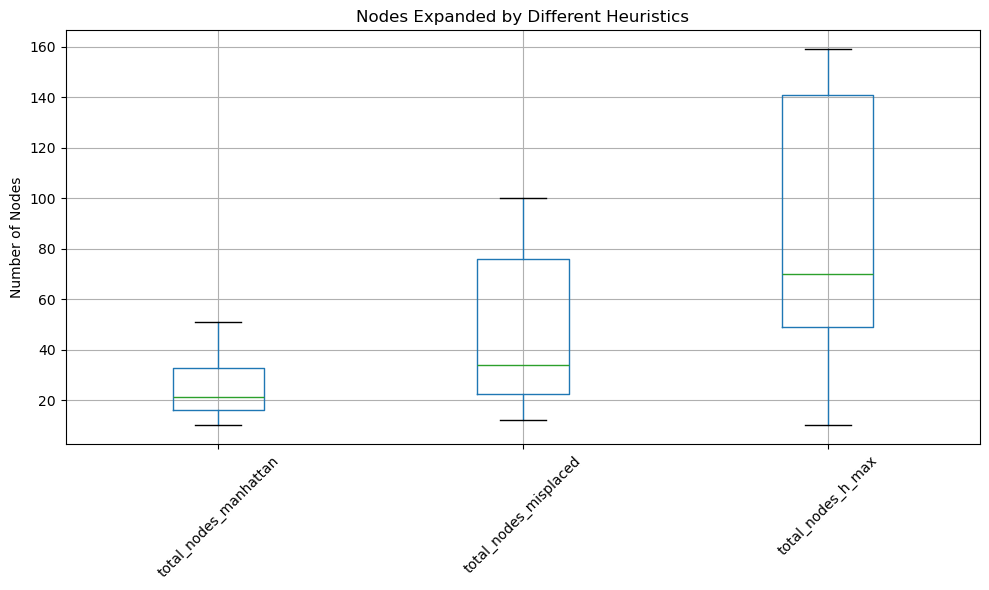

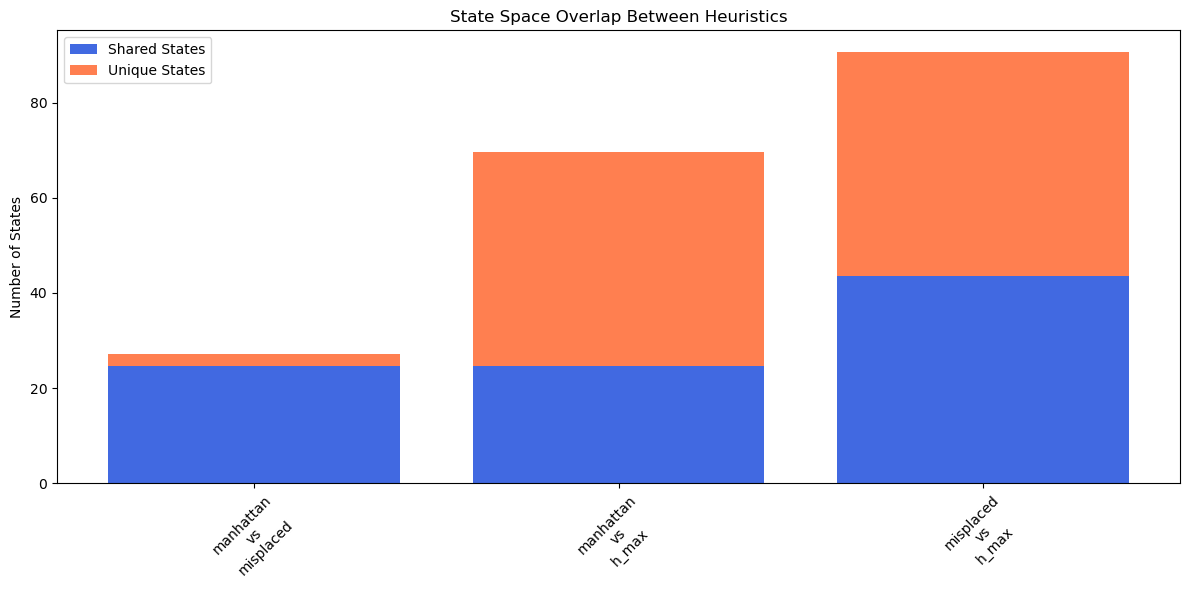

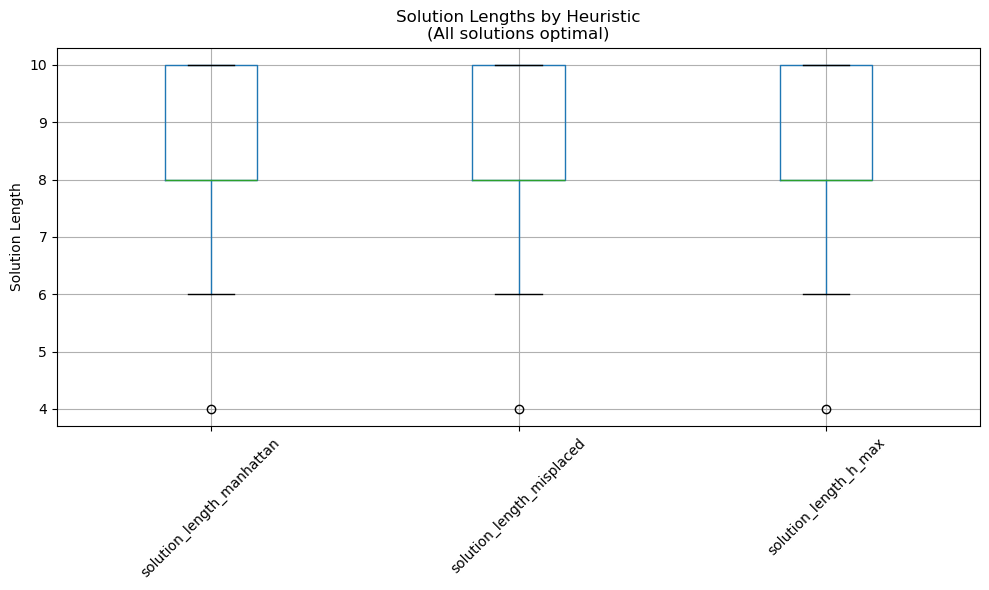

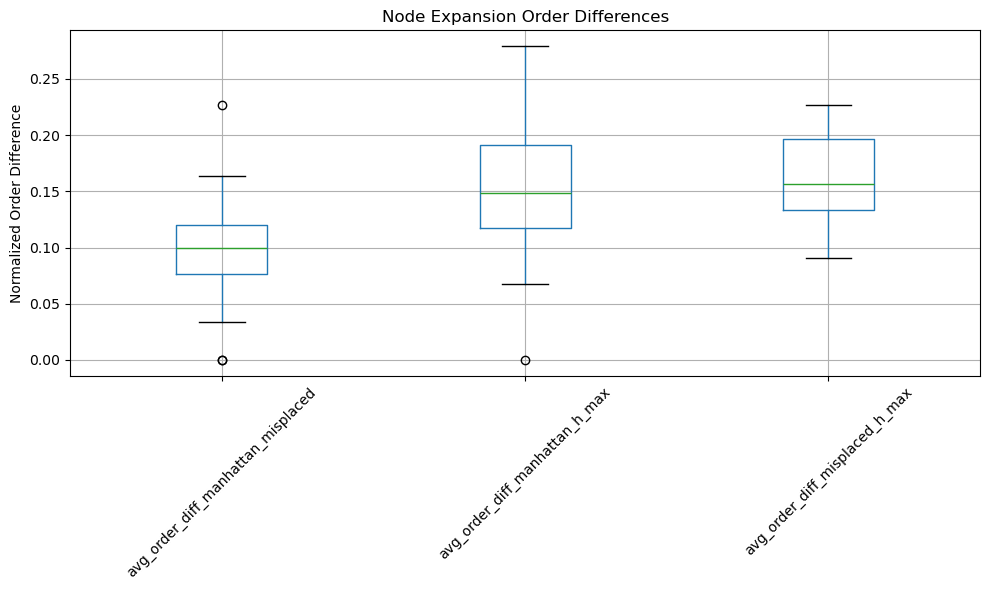


Solving problem 1
Using misplaced...
Using height_diff...
Using h_max...

Solving problem 2
Using misplaced...
Using height_diff...
Using h_max...

Solving problem 3
Using misplaced...
Using height_diff...
Using h_max...

Solving problem 4
Using misplaced...
Using height_diff...
Using h_max...

Solving problem 5
Using misplaced...
Using height_diff...
Using h_max...

Solving problem 6
Using misplaced...
Using height_diff...
Using h_max...

Solving problem 7
Using misplaced...
Using height_diff...
Using h_max...

Solving problem 8
Using misplaced...
Using height_diff...
Using h_max...

Solving problem 9
Using misplaced...
Using height_diff...
Using h_max...

Solving problem 10
Using misplaced...
Using height_diff...
Using h_max...

Solving problem 11
Using misplaced...
Using height_diff...
Using h_max...

Solving problem 12
Using misplaced...
Using height_diff...
Using h_max...

Solving problem 13
Using misplaced...
Using height_diff...
Using h_max...

Solving problem 14
Using misplace

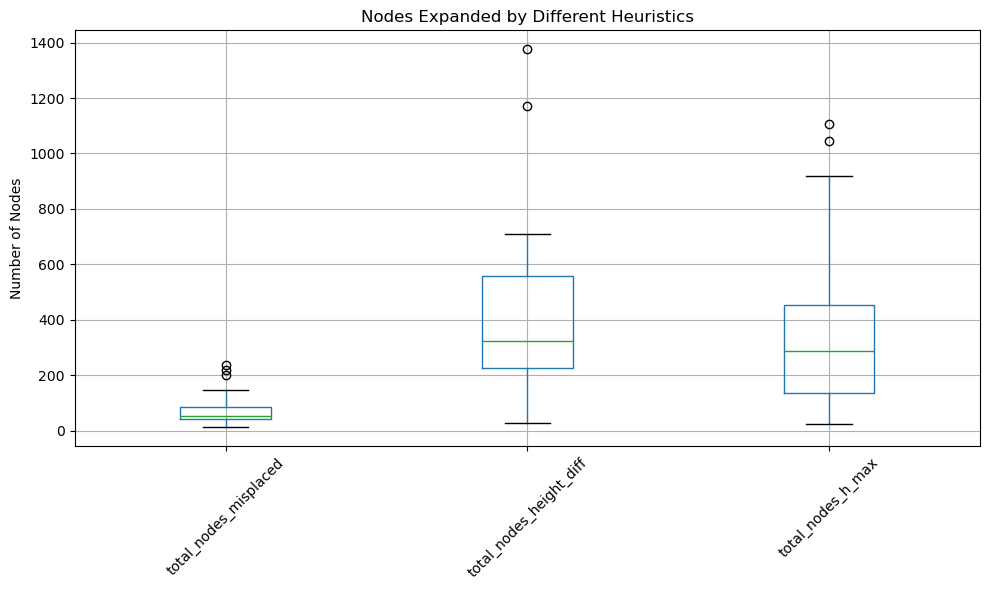

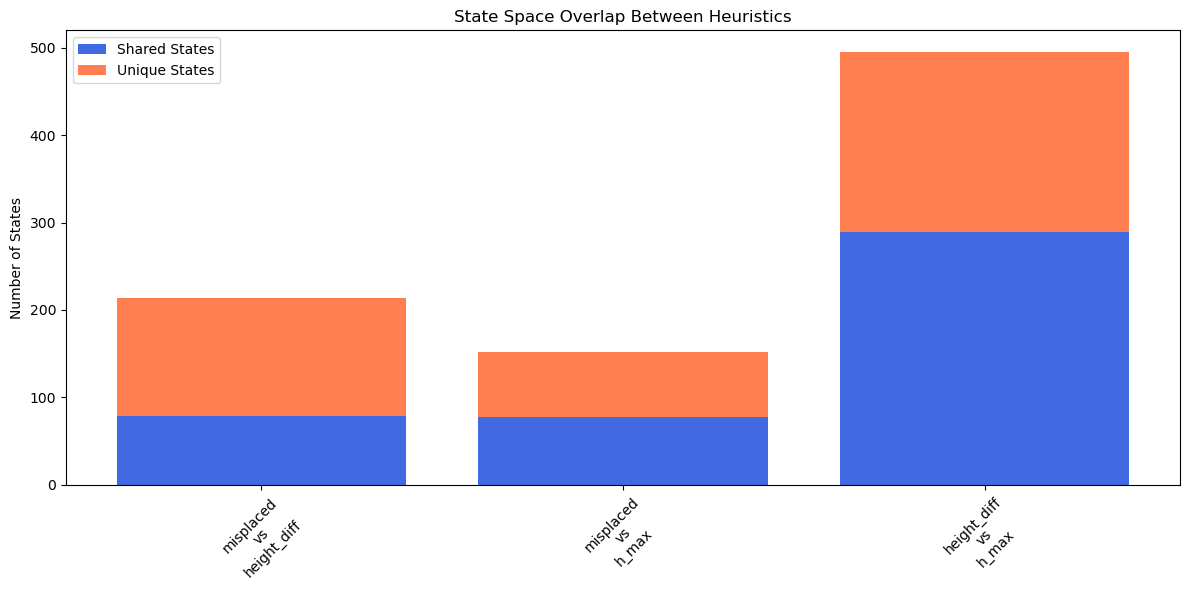

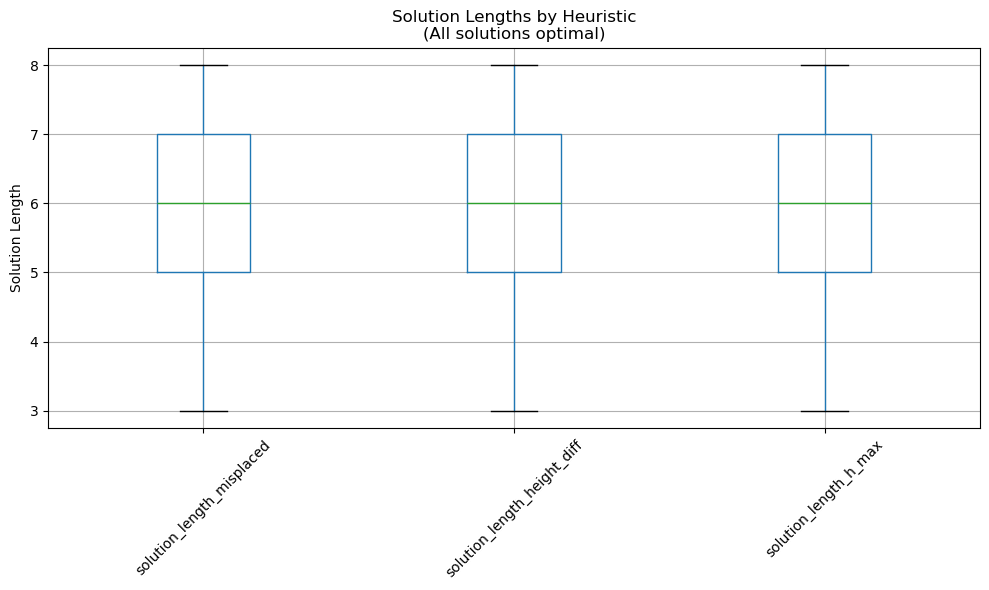

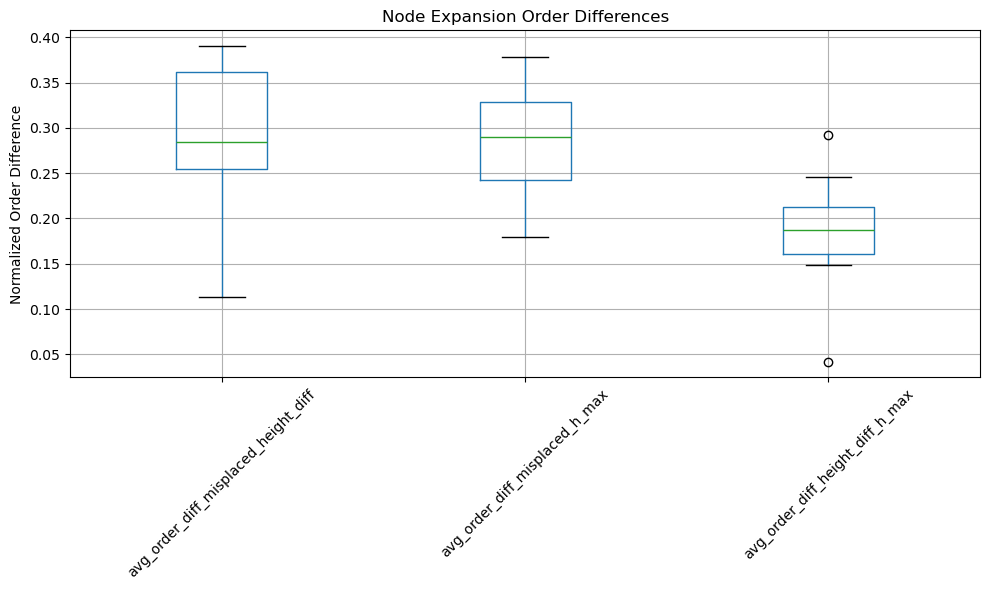

In [20]:
import numpy as np
import pandas as pd
from collections import defaultdict
from typing import Dict, Set, List, Tuple
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

from sliding_puzzle_generator import generate_sliding_puzzle_problem
from block_world_generator import generate_block_world_problem
from general_A_star import a_star
from sliding_puzzle_heuristics import sp_manhattan_distance, sp_misplaced_tiles, sp_h_max
from block_world_heuristics import bw_misplaced_blocks, bw_height_difference, bw_h_max

class HeuristicComparison:
    def __init__(self, domain: str):
        self.domain = domain
        self.problem_generators = {
            'sliding_puzzle': generate_sliding_puzzle_problem,
            'blocks_world': generate_block_world_problem
        }
        self.heuristics = {
            'sliding_puzzle': {
                'manhattan': sp_manhattan_distance,
                'misplaced': sp_misplaced_tiles,
                'h_max': sp_h_max
            },
            'blocks_world': {
                'misplaced': bw_misplaced_blocks,
                'height_diff': bw_height_difference,
                'h_max': bw_h_max
            }
        }

    def generate_problems(self, num_problems: int, **kwargs) -> List[Tuple]:
        problems = []
        for _ in range(num_problems):
            initial_state, goal_state = self.problem_generators[self.domain](**kwargs)
            problems.append((initial_state, goal_state))
        return problems

    def solve_with_heuristics(self, problems: List[Tuple]) -> List[Dict]:
        """Solve each problem with all available heuristics"""
        all_results = []

        for i, (initial_state, goal_state) in enumerate(problems):
            print(f"\nSolving problem {i+1}")
            problem_results = {}
            success = True

            # Try to solve with each heuristic
            for heur_name, heur_func in self.heuristics[self.domain].items():
                print(f"Using {heur_name}...")
                solution, search_tree = a_star(initial_state, goal_state, heur_func)

                if solution is None:
                    print(f"Failed to solve with {heur_name}")
                    success = False
                    break

                problem_results[heur_name] = {
                    'search_tree': search_tree,
                    'solution_length': len(solution)
                }

            # Only include results if all heuristics succeeded
            if success:
                metrics = self._analyze_search_trees(problem_results)
                all_results.append(metrics)

        return all_results

    def _analyze_search_trees(self, problem_results: Dict) -> Dict:
        """Analyze search trees and compute comparison metrics"""
        metrics = {}
        heuristics = list(problem_results.keys())

        # Basic metrics - total nodes and solution length for each heuristic
        solution_lengths = []
        for heur in heuristics:
            tree = problem_results[heur]['search_tree']
            metrics[f'total_nodes_{heur}'] = self._count_nodes(tree)
            solution_length = problem_results[heur]['solution_length']
            metrics[f'solution_length_{heur}'] = solution_length
            solution_lengths.append(solution_length)

        # Check if all heuristics found solutions of the same length
        metrics['all_solutions_optimal'] = len(set(solution_lengths)) == 1
        if not metrics['all_solutions_optimal']:
            print(f"Warning: Different solution lengths found: {dict(zip(heuristics, solution_lengths))}")

        # Pairwise comparisons between heuristics
        for i, heur1 in enumerate(heuristics):
            for heur2 in heuristics[i+1:]:
                tree1 = problem_results[heur1]['search_tree']
                tree2 = problem_results[heur2]['search_tree']

                # Get state-to-serial mappings for both trees
                map1 = self._get_state_serial_map(tree1)
                map2 = self._get_state_serial_map(tree2)

                # Find shared and unique states
                states1 = set(map1.keys())
                states2 = set(map2.keys())
                shared_states = states1.intersection(states2)
                only_in_1 = states1 - states2
                only_in_2 = states2 - states1

                # State space overlap metrics
                metrics[f'shared_states_{heur1}_{heur2}'] = len(shared_states)
                metrics[f'unique_to_{heur1}'] = len(only_in_1)
                metrics[f'unique_to_{heur2}'] = len(only_in_2)

                # Expansion order difference metrics (only for shared states)
                if shared_states:
                    # Calculate relative order differences
                    order_diffs = []
                    max_serial1 = max(map1.values())
                    max_serial2 = max(map2.values())

                    for state in shared_states:
                        # Normalize serial numbers to [0,1] range for fair comparison
                        norm_serial1 = map1[state] / max_serial1
                        norm_serial2 = map2[state] / max_serial2
                        order_diff = abs(norm_serial1 - norm_serial2)
                        order_diffs.append(order_diff)

                    metrics[f'avg_order_diff_{heur1}_{heur2}'] = sum(order_diffs) / len(order_diffs)
                    metrics[f'max_order_diff_{heur1}_{heur2}'] = max(order_diffs)
                else:
                    # If no shared states, set order differences to -1
                    metrics[f'avg_order_diff_{heur1}_{heur2}'] = -1
                    metrics[f'max_order_diff_{heur1}_{heur2}'] = -1

        return metrics

    def _count_nodes(self, root) -> int:
        count = 1
        for child in root.children:
            count += self._count_nodes(child)
        return count

    def _get_state_serial_map(self, root) -> Dict:
        state_map = {}

        def traverse(node):
            state_map[str(node.state)] = node.serial_number
            for child in node.children:
                traverse(child)

        traverse(root)
        return state_map

    def run_comparison(self, num_problems: int, save_results=True, **kwargs):
        """Run full comparison and save results"""
        problems = self.generate_problems(num_problems, **kwargs)
        results = self.solve_with_heuristics(problems)

        if not results:
            print("No problems were solved successfully by all heuristics")
            return None

        df = pd.DataFrame(results)

        if save_results:
            filename = f"heuristic_comparison_{self.domain}.csv"
            df.to_csv(filename, index=False)

        return df

    def plot_results(self, df: pd.DataFrame):
        """Create visualizations of the comparison results"""
        if df is None or df.empty:
            print("No results to plot")
            return

        # Node count comparison
        node_cols = [col for col in df.columns if col.startswith('total_nodes_')]
        plt.figure(figsize=(10, 6))
        df[node_cols].boxplot()
        plt.title('Nodes Expanded by Different Heuristics')
        plt.ylabel('Number of Nodes')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # State overlap comparison
        plt.figure(figsize=(12, 6))
        heuristics = list(self.heuristics[self.domain].keys())
        x_positions = []
        x_labels = []

        for i, h1 in enumerate(heuristics):
            for h2 in heuristics[i+1:]:
                if f'shared_states_{h1}_{h2}' in df.columns:
                    shared = df[f'shared_states_{h1}_{h2}'].mean()
                    only_h1 = df[f'unique_to_{h1}'].mean()
                    only_h2 = df[f'unique_to_{h2}'].mean()
                    unique_total = only_h1 + only_h2

                    x_pos = len(x_positions)
                    x_positions.append(x_pos)
                    x_labels.append(f'{h1}\nvs\n{h2}')

                    plt.bar([x_pos], [shared], color='royalblue',
                           label='Shared States' if x_pos == 0 else "")
                    plt.bar([x_pos], [unique_total], bottom=[shared], color='coral',
                           label='Unique States' if x_pos == 0 else "")

        plt.title('State Space Overlap Between Heuristics')
        plt.ylabel('Number of States')
        plt.legend()
        plt.xticks(x_positions, x_labels, rotation=45)
        plt.tight_layout()
        plt.show()

        # Solution length comparison
        length_cols = [col for col in df.columns if col.startswith('solution_length_')]
        non_optimal = (~df['all_solutions_optimal']).sum()

        plt.figure(figsize=(10, 6))
        df[length_cols].boxplot()
        if non_optimal > 0:
            plt.title(f'Solution Lengths by Heuristic\n⚠️ {non_optimal} cases with non-optimal solutions')
        else:
            plt.title('Solution Lengths by Heuristic\n(All solutions optimal)')
        plt.ylabel('Solution Length')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Order difference comparison
        plt.figure(figsize=(10, 6))
        diff_cols = [col for col in df.columns if col.startswith('avg_order_diff_')]
        if diff_cols:
            df[diff_cols].boxplot()
            plt.title('Node Expansion Order Differences')
            plt.ylabel('Normalized Order Difference')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

def main():
    # Example usage for Sliding Puzzle
    sp_comparison = HeuristicComparison('sliding_puzzle')
    sp_results = sp_comparison.run_comparison(
        num_problems=20,
        size=3,  # 3x3 puzzle
        num_moves=10
    )
    sp_comparison.plot_results(sp_results)

    # Example usage for Blocks World
    bw_comparison = HeuristicComparison('blocks_world')
    bw_results = bw_comparison.run_comparison(
        num_problems=20,
        num_blocks=5,
        num_stacks=3,
        num_moves=10
    )
    bw_comparison.plot_results(bw_results)

if __name__ == "__main__":
    main()

# With solution length accross many parameters

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from typing import Dict, Set, List, Tuple
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

from sliding_puzzle_generator import generate_sliding_puzzle_problem
from block_world_generator import generate_block_world_problem
from general_A_star import a_star
from sliding_puzzle_heuristics import sp_manhattan_distance, sp_misplaced_tiles, sp_h_max
from block_world_heuristics import bw_misplaced_blocks, bw_height_difference, bw_h_max

class HeuristicComparison:
    def __init__(self, domain: str):
        """Initialize comparison analysis for either 'sliding_puzzle' or 'blocks_world'"""
        self.domain = domain
        self.problem_generators = {
            'sliding_puzzle': generate_sliding_puzzle_problem,
            'blocks_world': generate_block_world_problem
        }
        self.heuristics = {
            'sliding_puzzle': {
                'manhattan': sp_manhattan_distance,
                'misplaced': sp_misplaced_tiles,
                'h_max': sp_h_max
            },
            'blocks_world': {
                'misplaced': bw_misplaced_blocks,
                'height_diff': bw_height_difference,
                'h_max': bw_h_max
            }
        }

    def generate_problems(self, num_problems: int, **kwargs) -> List[Tuple]:
        """Generate multiple problem instances"""
        problems = []
        for _ in range(num_problems):
            initial_state, goal_state = self.problem_generators[self.domain](**kwargs)
            problems.append((initial_state, goal_state))
        return problems

    def solve_with_heuristics(self, problems: List[Tuple]) -> List[Dict]:
        """Solve each problem with all available heuristics"""
        all_results = []

        for i, (initial_state, goal_state) in enumerate(problems):
            print(f"\nSolving problem {i+1}")
            problem_results = {}
            success = True

            # Try to solve with each heuristic
            for heur_name, heur_func in self.heuristics[self.domain].items():
                print(f"Using {heur_name}...")
                solution, search_tree = a_star(initial_state, goal_state, heur_func)

                if solution is None:
                    print(f"Failed to solve with {heur_name}")
                    success = False
                    break

                problem_results[heur_name] = {
                    'search_tree': search_tree,
                    'solution_length': len(solution)
                }

            # Only include results if all heuristics succeeded
            if success:
                metrics = self._analyze_search_trees(problem_results)
                all_results.append(metrics)

        return all_results

    def _analyze_search_trees(self, problem_results: Dict) -> Dict:
        """Analyze search trees and compute comparison metrics"""
        metrics = {}
        heuristics = list(problem_results.keys())

        # Basic metrics - total nodes and solution length for each heuristic
        for heur in heuristics:
            tree = problem_results[heur]['search_tree']
            metrics[f'total_nodes_{heur}'] = self._count_nodes(tree)
            metrics[f'solution_length_{heur}'] = problem_results[heur]['solution_length']

        # Check if solution lengths are identical
        lengths = [problem_results[heur]['solution_length'] for heur in heuristics]
        metrics['solution_lengths_identical'] = len(set(lengths)) == 1

        # Pairwise comparisons between heuristics
        for i, heur1 in enumerate(heuristics):
            for heur2 in heuristics[i+1:]:
                tree1 = problem_results[heur1]['search_tree']
                tree2 = problem_results[heur2]['search_tree']

                # Get state-to-serial mappings for both trees
                map1 = self._get_state_serial_map(tree1)
                map2 = self._get_state_serial_map(tree2)

                # Find shared and unique states
                states1 = set(map1.keys())
                states2 = set(map2.keys())
                shared_states = states1.intersection(states2)
                only_in_1 = states1 - states2
                only_in_2 = states2 - states1

                # State space overlap metrics
                metrics[f'shared_states_{heur1}_{heur2}'] = len(shared_states)
                metrics[f'unique_to_{heur1}'] = len(only_in_1)
                metrics[f'unique_to_{heur2}'] = len(only_in_2)

                # Expansion order difference metrics (only for shared states)
                if shared_states:
                    max_serial1 = max(map1.values())
                    max_serial2 = max(map2.values())

                    # Only calculate order differences if both trees have explored nodes
                    if max_serial1 > 0 and max_serial2 > 0:
                        order_diffs = []
                        for state in shared_states:
                            # Normalize serial numbers to [0,1] range for fair comparison
                            norm_serial1 = map1[state] / max_serial1
                            norm_serial2 = map2[state] / max_serial2
                            order_diff = abs(norm_serial1 - norm_serial2)
                            order_diffs.append(order_diff)

                        metrics[f'avg_order_diff_{heur1}_{heur2}'] = sum(order_diffs) / len(order_diffs)
                        metrics[f'max_order_diff_{heur1}_{heur2}'] = max(order_diffs)
                    else:
                        # If either tree has no explored nodes, set order differences to -1
                        metrics[f'avg_order_diff_{heur1}_{heur2}'] = -1
                        metrics[f'max_order_diff_{heur1}_{heur2}'] = -1
                else:
                    # If no shared states, set order differences to -1
                    metrics[f'avg_order_diff_{heur1}_{heur2}'] = -1
                    metrics[f'max_order_diff_{heur1}_{heur2}'] = -1

        return metrics

    def _count_nodes(self, root) -> int:
        """Count total nodes in a search tree"""
        count = 1
        for child in root.children:
            count += self._count_nodes(child)
        return count

    def _get_state_serial_map(self, root) -> Dict:
        """Create mapping of states to their serial numbers"""
        state_map = {}

        def traverse(node):
            state_map[str(node.state)] = node.serial_number
            for child in node.children:
                traverse(child)

        traverse(root)
        return state_map

    def run_comparison(self, num_problems: int, save_results=True, **kwargs):
        """Run full comparison and save results"""
        problems = self.generate_problems(num_problems, **kwargs)
        results = self.solve_with_heuristics(problems)

        if not results:
            print("No problems were solved successfully by all heuristics")
            return None

        df = pd.DataFrame(results)

        if save_results:
            filename = f"heuristic_comparison_{self.domain}.csv"
            df.to_csv(filename, index=False)

        return df

    def run_parameter_study(self):
        """Run comparisons across different parameter settings"""
        if self.domain == 'sliding_puzzle':
            # Different puzzle sizes and move counts
            params = [
                {'size': 4, 'num_moves': 5},
                {'size': 4, 'num_moves': 10},
                {'size': 4, 'num_moves': 15},
                {'size': 6, 'num_moves': 5},
                {'size': 6, 'num_moves': 10},
                {'size': 6, 'num_moves': 15}
            ]
        else:  # blocks_world
            # Different combinations of blocks, stacks, and moves
            params = [
                {'num_blocks': 5, 'num_stacks': 3, 'num_moves': 7},
                {'num_blocks': 5, 'num_stacks': 3, 'num_moves': 11},
                {'num_blocks': 5, 'num_stacks': 3, 'num_moves': 15},
                {'num_blocks': 7, 'num_stacks': 4, 'num_moves': 7},
                {'num_blocks': 7, 'num_stacks': 4, 'num_moves': 11},
                {'num_blocks': 7, 'num_stacks': 4, 'num_moves': 15},
                {'num_blocks': 9, 'num_stacks': 5, 'num_moves': 7},
                {'num_blocks': 9, 'num_stacks': 5, 'num_moves': 11},
                {'num_blocks': 9, 'num_stacks': 5, 'num_moves': 15}
            ]

        results = []
        for param_set in params:
            print(f"\nRunning comparison with parameters: {param_set}")
            result = self.run_comparison(num_problems=10, **param_set)
            if result is not None and not result.empty:
                results.append((param_set, result))

        if not results:
            print("No successful comparisons to plot")
            return

        self.plot_parameter_study(results)

    def plot_parameter_study(self, results):
        """Create a collage of plots for different parameter settings"""
        n_comparisons = len(results)
        if n_comparisons == 0:
            return

        # Determine grid layout
        n_cols = min(3, n_comparisons)
        n_rows = (n_comparisons + n_cols - 1) // n_cols

        # Create figure for node counts
        plt.figure(figsize=(6*n_cols, 5*n_rows))
        plt.suptitle('Nodes Expanded by Different Heuristics Across Parameters', y=1.02)

        for idx, (params, df) in enumerate(results):
            plt.subplot(n_rows, n_cols, idx+1)
            node_cols = [col for col in df.columns if col.startswith('total_nodes_')]
            df[node_cols].boxplot()

            # Create parameter string
            param_str = '\n'.join(f'{k}={v}' for k, v in params.items())
            plt.title(f'Parameters:\n{param_str}')
            plt.xticks(rotation=45)
            plt.ylabel('Number of Nodes')

        plt.tight_layout()
        plt.show()

        # Create figure for state overlap
        plt.figure(figsize=(6*n_cols, 5*n_rows))
        plt.suptitle('State Space Overlap Between Heuristics Across Parameters', y=1.02)

        for idx, (params, df) in enumerate(results):
            plt.subplot(n_rows, n_cols, idx+1)

            heuristics = list(self.heuristics[self.domain].keys())
            x_positions = []
            x_labels = []

            for i, h1 in enumerate(heuristics):
                for h2 in heuristics[i+1:]:
                    if f'shared_states_{h1}_{h2}' in df.columns:
                        shared = df[f'shared_states_{h1}_{h2}'].mean()
                        only_h1 = df[f'unique_to_{h1}'].mean()
                        only_h2 = df[f'unique_to_{h2}'].mean()
                        unique_total = only_h1 + only_h2

                        x_pos = len(x_positions)
                        x_positions.append(x_pos)
                        x_labels.append(f'{h1}\nvs\n{h2}')

                        plt.bar([x_pos], [shared], color='royalblue',
                               label='Shared States' if idx == 0 and x_pos == 0 else "")
                        plt.bar([x_pos], [unique_total], bottom=[shared], color='coral',
                               label='Unique States' if idx == 0 and x_pos == 0 else "")

            # Create parameter string
            param_str = '\n'.join(f'{k}={v}' for k, v in params.items())
            plt.title(f'Parameters:\n{param_str}')
            plt.xticks(x_positions, x_labels, rotation=45)
            plt.ylabel('Number of States')

            if idx == 0:  # Only show legend on first subplot
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()

        # Create figure for solution lengths if any differences were found
        if any(not df['solution_lengths_identical'].all() for _, df in results):
            plt.figure(figsize=(6*n_cols, 5*n_rows))
            plt.suptitle('Solution Lengths Across Different Heuristics', y=1.02)

            for idx, (params, df) in enumerate(results):
                plt.subplot(n_rows, n_cols, idx+1)
                length_cols = [col for col in df.columns if col.startswith('solution_length_')]
                df[length_cols].boxplot()

                non_identical = (~df['solution_lengths_identical']).sum()
                if non_identical > 0:
                    plt.title(f'Parameters:\n{param_str}\n⚠️ {non_identical} cases with different lengths')
                else:
                    plt.title(f'Parameters:\n{param_str}\n(All solutions optimal)')

                plt.xticks(rotation=45)
                plt.ylabel('Solution Length')

            plt.tight_layout()
            plt.show()

        # Create figure for order differences
        plt.figure(figsize=(6*n_cols, 5*n_rows))
        plt.suptitle('Node Expansion Order Differences Across Parameters', y=1.02)

        for idx, (params, df) in enumerate(results):
            plt.subplot(n_rows, n_cols, idx+1)
            diff_cols = [col for col in df.columns if col.startswith('avg_order_diff_')]
            if diff_cols:
                df[diff_cols].boxplot()

                # Create parameter string
                param_str = '\n'.join(f'{k}={v}' for k, v in params.items())
                plt.title(f'Parameters:\n{param_str}')
                plt.xticks(rotation=45)
                plt.ylabel('Normalized Order Difference')

        plt.tight_layout()
        plt.show()

def main():
    # Run parameter study for Sliding Puzzle
    print("Running Sliding Puzzle parameter study...")
    sp_comparison = HeuristicComparison('sliding_puzzle')
    sp_comparison.run_parameter_study()

    # Run parameter study for Blocks World
    print("\nRunning Blocks World parameter study...")
    bw_comparison = HeuristicComparison('blocks_world')
    bw_comparison.run_parameter_study()

if __name__ == "__main__":
    main()

Running Sliding Puzzle parameter study...

Running comparison with parameters: {'size': 4, 'num_moves': 5}

Solving problem 1
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 2
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 3
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 4
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 5
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 6
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 7
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 8
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 9
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 10
Using manhattan...
Using misplaced...
Using h_max...

Running comparison with parameters: {'size': 4, 'num_moves': 10}

Solving problem 1
Using manhattan...
Using misplaced...
Using h_max...

Solving problem 2
Using manhattan